In [1]:
import numpy as np
import pandas as pd

test_data_df = pd.read_csv('transposed_flattened_test_data.csv', skiprows=[0], header=None)

labels = test_data_df.iloc[0, :]  # 2행이 실제 라벨 데이터이므로 첫 번째 행으로 지정

# 세 번째 행부터 마지막 행까지를 픽셀 데이터로 사용 (열로 유지)
pixels = test_data_df.iloc[1:, :].astype(float)  # 픽셀 값으로 사용될 행들

V_read = 0.1

#normalized_pixels = pixels / 255.0

voltage_pixels = pixels * V_read


voltage_pixels_with_labels = pd.concat([labels.to_frame().T, voltage_pixels], ignore_index=True)

output_file_path = 'vred_mapping_testset_v3.csv'
voltage_pixels_with_labels.to_csv(output_file_path, index=False, header=False)  # 헤더 없이 저장
print(f"Voltage mapped test set saved to {output_file_path}.")
print(voltage_pixels_with_labels)
max_voltage = np.max(voltage_pixels)
min_voltage = np.min(voltage_pixels)
print("Max voltage : ", max_voltage)
print("Min voltage : ", min_voltage)

Voltage mapped test set saved to vred_mapping_testset_v3.csv.
       0         1         2         3         4         5         6      \
0   1.000000  7.000000  7.000000  5.000000  7.000000  1.000000  8.000000   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000392  0.000000  0.000000  0.000000   
4   0.001961  0.000000  0.000000  0.008627  0.000000  0.000000  0.000784   
..       ...       ...       ...       ...       ...       ...       ...   
60  0.000784  0.017647  0.006667  0.000000  0.028235  0.004314  0.005490   
61  0.003529  0.053725  0.056078  0.000000  0.000392  0.001176  0.002745   
62  0.000392  0.005490  0.013333  0.000000  0.000000  0.000000  0.000000   
63  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
64  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

       7         8       

Plot saved as 'figure_result_plot_avg.png'


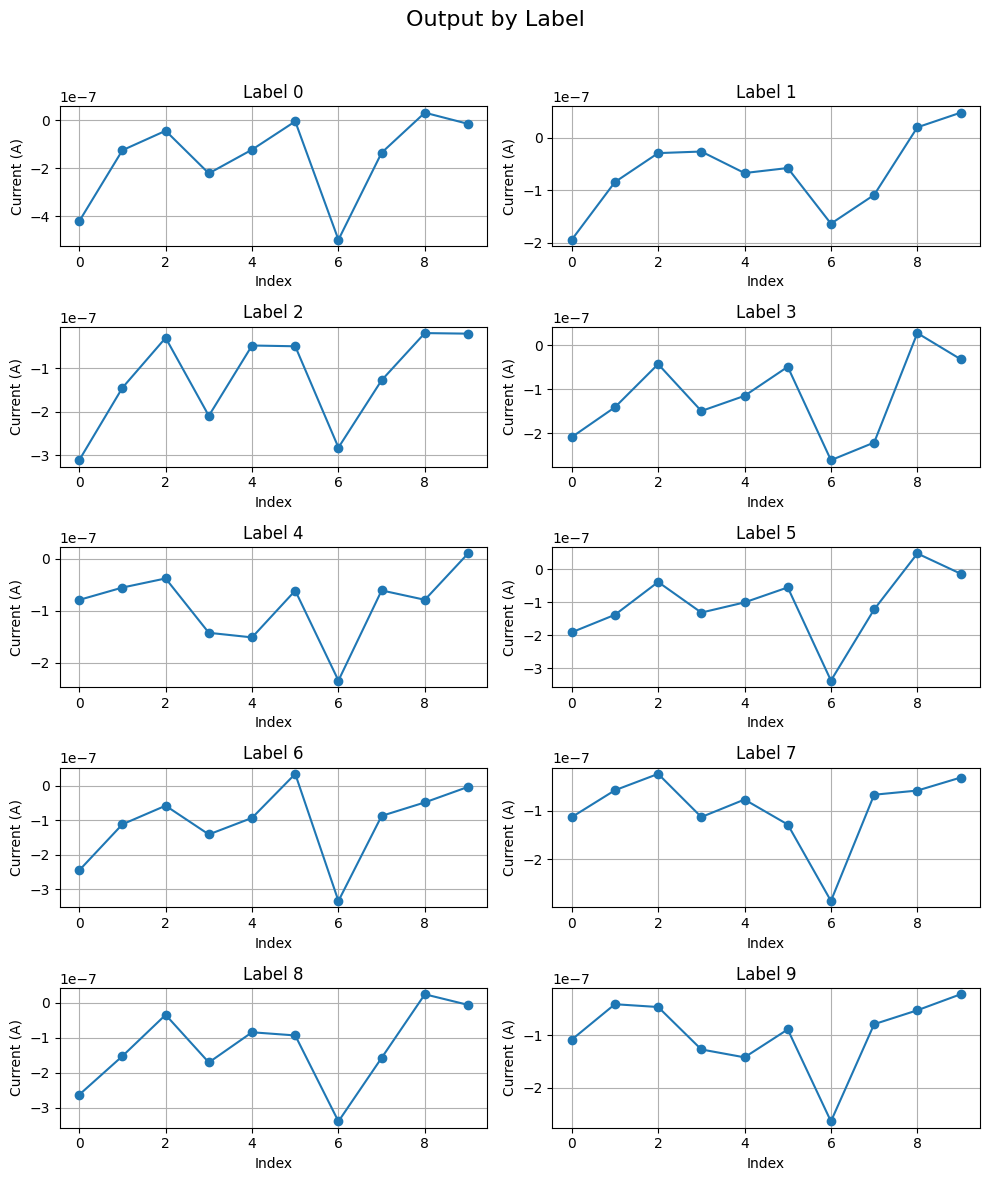

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로드
vred_mapping_path = 'vred_mapping_testset_v3.csv'
conductance_positive_path = 'conductance_positive_ann_v3.csv'
conductance_negative_path = 'conductance_negative_ann_v3.csv'

# Load voltage data
voltage_data_df = pd.read_csv(vred_mapping_path, header=None)
labels = voltage_data_df.iloc[0, :]  # 첫 번째 행은 라벨
voltage_values = voltage_data_df.iloc[1:, :].astype(float)  # 나머지 행은 전압 값

# Load conductance data
conductance_positive_df = pd.read_csv(conductance_positive_path, skiprows=[0],header=None).iloc[1:, :]
conductance_negative_df = pd.read_csv(conductance_negative_path,skiprows=[0], header=None).iloc[1:, :]

conductance_positive = conductance_positive_df.values.astype(float)
conductance_negative = conductance_negative_df.values.astype(float)

# 2. 전류 계산 및 저장
current_results = {}
label_outputs = {i: [] for i in range(10)}  # 각 라벨에 대한 결과 저장

for col_idx in range(voltage_values.shape[1]):
    label = int(labels[col_idx])  # 현재 열의 라벨
    voltage_column = voltage_values.iloc[:, col_idx].values  # 열 데이터
    voltage_column = voltage_column[:, np.newaxis]  # 2D 배열로 변환

    # Positive and Negative current 계산
    positive_current = np.sum(voltage_column * conductance_positive, axis=0)
    negative_current = np.sum(voltage_column * conductance_negative, axis=0)

    # Net current 계산
    net_current = positive_current - negative_current
    sample_key = f"sample_{label}_{len(label_outputs[label]) + 1}"
    current_results[sample_key] = net_current
    label_outputs[label].append(net_current)

# 3. 라벨별 평균 전류 계산
label_mean_currents = {}
for label in range(10):
    if label_outputs[label]:
        label_mean_currents[label] = np.mean(label_outputs[label], axis=0)  # 평균 계산

# 4. 시각화
fig, axes = plt.subplots(5, 2, figsize=(10, 12))
fig.suptitle('Output by Label', fontsize=16)

for i in range(10):
    avg_output = label_mean_currents[i]
    x_indices = range(len(avg_output))  # 인덱스 생성
    ax = axes[i // 2, i % 2]
    ax.plot(x_indices, avg_output, marker='o')
    ax.set_title(f'Label {i}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Current (A)')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figure8_result_plot_avg.png')
print("Plot saved as 'figure_result_plot_avg.png'")



Plot saved as 'figure8_result_plot_scaled.png'


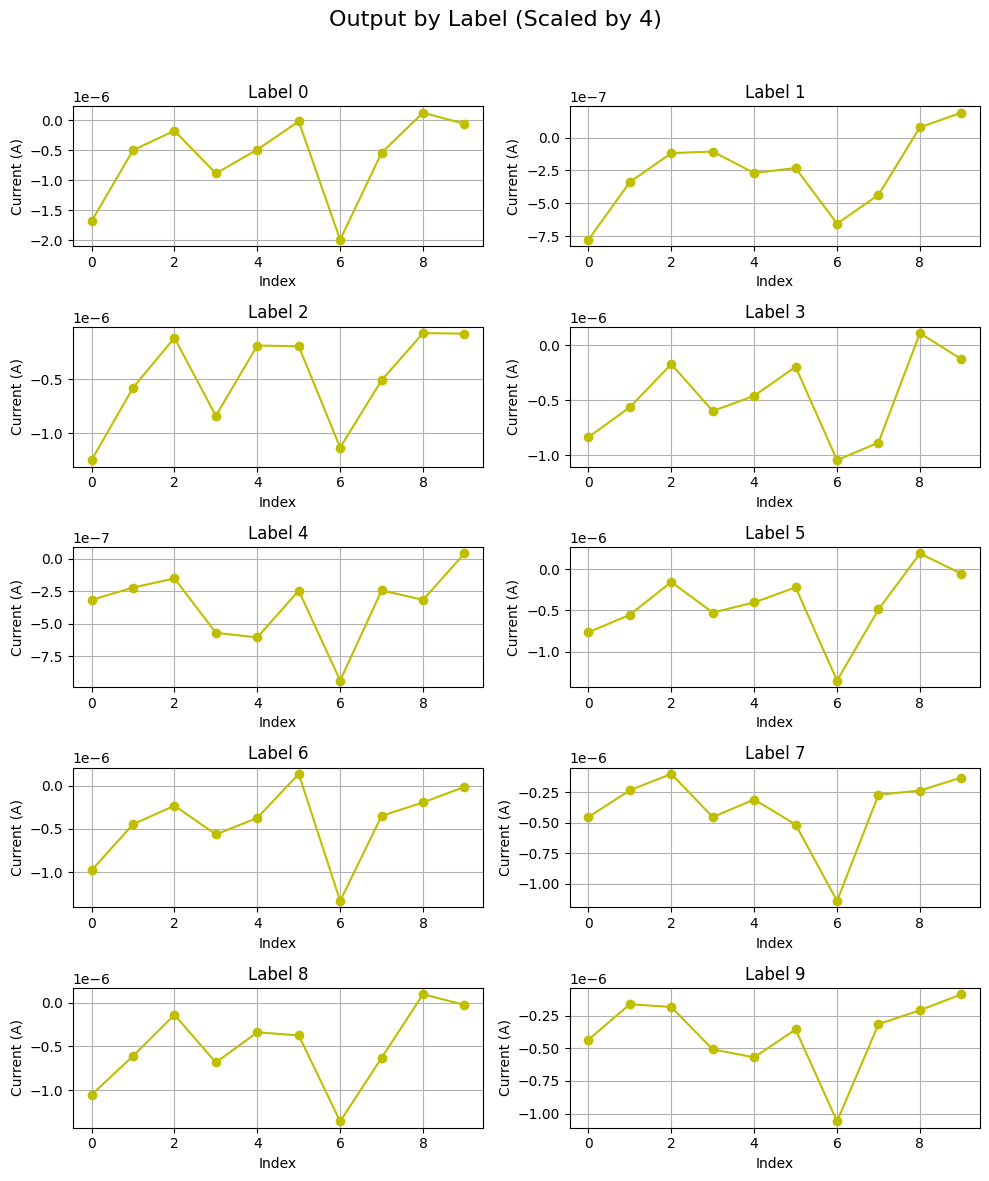

In [4]:
# 1. 모든 전류 값에 4를 곱하기
current_results_scaled = {key: np.array(value) * 4 for key, value in current_results.items()}
label_outputs_scaled = {label: [np.array(current) * 4 for current in currents] for label, currents in label_outputs.items()}

# 2. 라벨별 평균 전류 값 다시 계산
label_mean_currents_scaled = {}
for label in range(10):
    if label_outputs_scaled[label]:
        label_mean_currents_scaled[label] = np.mean(label_outputs_scaled[label], axis=0)  # 평균 계산

# 3. 다시 시각화
fig, axes = plt.subplots(5, 2, figsize=(10, 12))
fig.suptitle('Output by Label (Scaled by 4)', fontsize=16)

for i in range(10):
    avg_output = label_mean_currents_scaled[i]
    x_indices = range(len(avg_output))  # 인덱스 생성
    ax = axes[i // 2, i % 2]
    ax.plot(x_indices, avg_output, marker='o', color='y')
    ax.set_title(f'Label {i}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Current (A)')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figure8_result_plot_scaled.png')
print("Plot saved as 'figure8_result_plot_scaled.png'")



Plot saved as 'figure8_result_plot_4section.png'


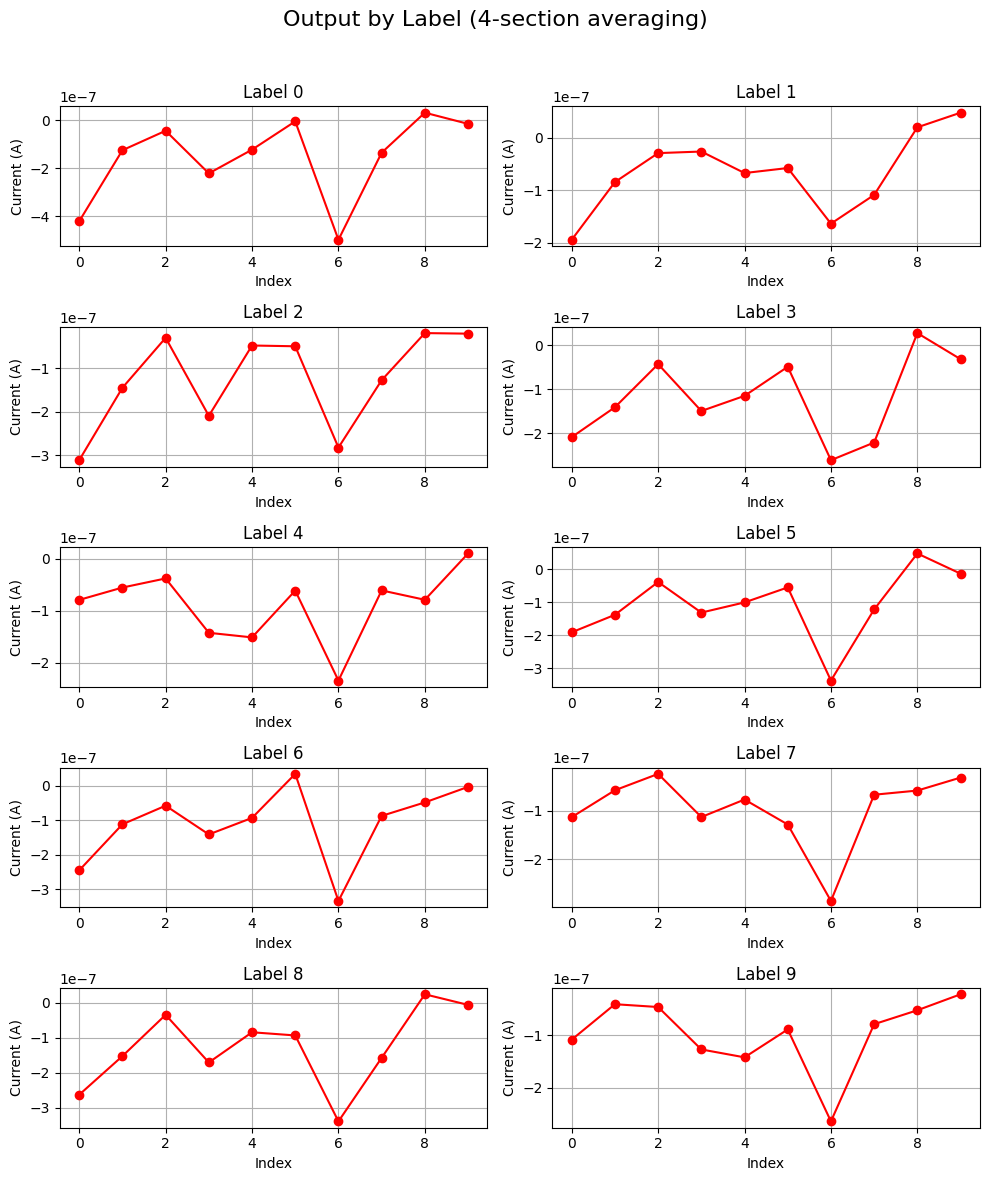

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로드
vred_mapping_path = 'vred_mapping_testset_v3.csv'
conductance_positive_path = 'conductance_positive_ann_v3.csv'
conductance_negative_path = 'conductance_negative_ann_v3.csv'

# Load voltage data
voltage_data_df = pd.read_csv(vred_mapping_path, header=None)
labels = voltage_data_df.iloc[0, :]  # 첫 번째 행은 라벨
voltage_values = voltage_data_df.iloc[1:, :].astype(float)  # 나머지 행은 전압 값

# Load conductance data
conductance_positive_df = pd.read_csv(conductance_positive_path,skiprows=[0], header=None).iloc[1:, :]
conductance_negative_df = pd.read_csv(conductance_negative_path,skiprows=[0], header=None).iloc[1:, :]

# Convert to numpy arrays for efficiency
conductance_positive = conductance_positive_df.values.astype(float)
conductance_negative = conductance_negative_df.values.astype(float)

# 2. 구간 나누기 (4등분)
n_sections = 4
split_indices = np.array_split(range(voltage_values.shape[0]), n_sections)

# 3. 전류 계산 및 저장
current_results = {}
label_outputs = {i: [] for i in range(10)}  # 각 라벨에 대한 결과 저장

for col_idx in range(voltage_values.shape[1]):
    label = int(labels[col_idx])  # 현재 열의 라벨
    voltage_column = voltage_values.iloc[:, col_idx].values  # 열 데이터

    # 4. 각 구간별로 전류 계산
    total_current = np.zeros(conductance_positive.shape[1])  # 전류 초기화
    for section_indices in split_indices:
        voltage_section = voltage_column[section_indices][:, np.newaxis]  # 전압 구간
        conductance_positive_section = conductance_positive[section_indices, :]
        conductance_negative_section = conductance_negative[section_indices, :]

        # Positive and Negative current 계산
        positive_current = np.sum(voltage_section * conductance_positive_section, axis=0)
        negative_current = np.sum(voltage_section * conductance_negative_section, axis=0)

        # Net current 계산
        total_current += (positive_current - negative_current)

    sample_key = f"sample_{label}_{len(label_outputs[label]) + 1}"
    current_results[sample_key] = total_current
    label_outputs[label].append(total_current)

# 5. 라벨별 평균 전류 계산
label_mean_currents = {}
for label in range(10):
    if label_outputs[label]:
        label_mean_currents[label] = np.mean(label_outputs[label], axis=0)  # 평균 계산

# 6. 시각화
fig, axes = plt.subplots(5, 2, figsize=(10, 12))
fig.suptitle('Output by Label (4-section averaging)', fontsize=16)

for i in range(10):
    avg_output = label_mean_currents[i]
    x_indices = range(len(avg_output))  # 인덱스 생성
    ax = axes[i // 2, i % 2]
    ax.plot(x_indices, avg_output, marker='o', color='r')
    ax.set_title(f'Label {i}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Current (A)')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figure8_result_plot_4section.png')
print("Plot saved as 'figure8_result_plot_4section.png'")
